In [11]:
from models.models import create_model
import util.util as util
import os
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import cv2
from PIL import Image
import torch.utils.data as data
from torch.autograd import Variable
import os.path as osp
import torchvision.transforms as transforms
import json
from PIL import ImageDraw
import itertools
import matplotlib.pyplot as plt
import torch.nn.functional as F
SIZE = 320
NC = 14

In [12]:
class Args:
    name = 'label2city'
    gpu_ids = [0, 1, 2, 3]
    checkpoints_dir = './checkpoints'
    model = 'pix2pixHD'
    norm = 'instance'
    use_dropout = True
    verbose = True
    batchSize = 1
    loadSize = 512
    fineSize = 512
    label_nc = 20
    input_nc = 3
    output_nc = 3
    dataroot = '../../after_vton_difficult_v2/'
    datapairs = 'mixed_pairs.txt'
    resize_or_crop = 'scale_width'
    serial_batches = True
    no_flip = True
    nThreads = 2
    max_dataset_size = float("inf")
    display_winsize = 512
    tf_log = True
    netG = 'global'
    ngf = 64
    n_downsample_global = 4
    n_blocks_global = 4
    n_blocks_local = 3
    n_local_enhancers = 1
    niter_fix_global = 0
    continue_train = True
    display_freq = 100
    print_freq = 100
    save_latest_freq = 1000
    save_epoch_freq = 10 
    no_html = True
    debug = True
    load_pretrain = '../label2city'
    which_epoch = 'latest'
    phase = 'test'
    niter = 100
    niter_decay = 100
    beta1 = 0.5
    lr = 0.0002
    num_D = 2
    n_layers_D = 3
    ndf = 64
    lambda_feat = 10.0
    no_ganFeat_loss = True
    no_vgg_loss = False
    no_lsgan = True
    pool_size = 0
    isTrain = True

opt = Args

In [13]:
class UnetMask(nn.Module):
    def __init__(self, input_nc, output_nc=3):
        super(UnetMask, self).__init__()
        self.stn = STNNet()
        nl = nn.InstanceNorm2d
        self.conv1 = nn.Sequential(*[nn.Conv2d(input_nc, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU(),
                                     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU()])
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Sequential(*[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU(),
                                     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU()])
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Sequential(*[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU(),
                                     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU()])
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv4 = nn.Sequential(*[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU(),
                                     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU()])
        self.drop4 = nn.Dropout(0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv5 = nn.Sequential(*[nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1), nl(1024), nn.ReLU(),
                                     nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1), nl(1024), nn.ReLU()])
        self.drop5 = nn.Dropout(0.5)

        self.up6 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1), nl(512),
              nn.ReLU()])

        self.conv6 = nn.Sequential(*[nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU(),
                                     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU()])
        self.up7 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), nl(256),
              nn.ReLU()])
        self.conv7 = nn.Sequential(*[nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU(),
                                     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU()])

        self.up8 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nl(128),
              nn.ReLU()])

        self.conv8 = nn.Sequential(*[nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU(),
                                     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU()])

        self.up9 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), nl(64),
              nn.ReLU()])

        self.conv9 = nn.Sequential(*[nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU(),
                                     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nl(
                                         64), nn.ReLU(),
                                     nn.Conv2d(
                                         64, output_nc, kernel_size=3, stride=1, padding=1)
                                     ])

    def forward(self, input, refer, mask, grid):

        input, warped_mask, rx, ry, cx, cy, grid = self.stn(
            input, torch.cat([mask, refer, input], 1), mask, grid)
        # print(input.shape)

        conv1 = self.conv1(torch.cat([refer.detach(), input.detach()], 1))
        pool1 = self.pool1(conv1)

        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)

        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)

        conv4 = self.conv4(pool3)
        drop4 = self.drop4(conv4)
        pool4 = self.pool4(drop4)

        conv5 = self.conv5(pool4)
        drop5 = self.drop5(conv5)

        up6 = self.up6(drop5)
        conv6 = self.conv6(torch.cat([drop4, up6], 1))

        up7 = self.up7(conv6)
        conv7 = self.conv7(torch.cat([conv3, up7], 1))

        up8 = self.up8(conv7)
        conv8 = self.conv8(torch.cat([conv2, up8], 1))

        up9 = self.up9(conv8)
        conv9 = self.conv9(torch.cat([conv1, up9], 1))
        return conv9, input, warped_mask, grid

class STNNet(nn.Module):
    def __init__(self):
        super(STNNet, self).__init__()
        range = 0.9
        r1 = range
        r2 = range
        grid_size_h = 5
        grid_size_w = 5

        assert r1 < 1 and r2 < 1  # if >= 1, arctanh will cause error in BoundedGridLocNet
        target_control_points = torch.Tensor(list(itertools.product(
            np.arange(-r1, r1 + 0.00001, 2.0 * r1 / (grid_size_h - 1)),
            np.arange(-r2, r2 + 0.00001, 2.0 * r2 / (grid_size_w - 1)),
        )))
        Y, X = target_control_points.split(1, dim=1)
        target_control_points = torch.cat([X, Y], dim=1)
        self.target_control_points = target_control_points
        # self.get_row(target_control_points,5)
        GridLocNet = BoundedGridLocNet

        self.loc_net = GridLocNet(
            grid_size_h, grid_size_w, target_control_points)

        self.tps = TPSGridGen(256, 192, target_control_points)

    def get_row(self, coor, num):
        for j in range(num):
            sum = 0
            buffer = 0
            flag = False
            for i in range(num - 1):
                differ = (coor[j * num + i + 1, :] - coor[j * num + i, :]) ** 2
                if not flag:
                    second_dif = 0
                    flag = True
                else:
                    second_dif = torch.abs(differ - buffer)

                buffer = differ
                sum += second_dif
            print(sum / num)

    def get_col(self, coor, num):
        for i in range(num):
            sum = 0
            buffer = 0
            flag = False
            for j in range(num - 1):
                differ = (coor[(j + 1) * num + i, :] -
                          coor[j * num + i, :]) ** 2
                if not flag:
                    second_dif = 0
                    flag = True
                else:
                    second_dif = torch.abs(differ-buffer)

                buffer = differ
                sum += second_dif
            print(sum)

    def forward(self, x, reference, mask, grid_pic):
        batch_size = x.size(0)
        source_control_points, rx, ry, cx, cy = self.loc_net(reference)
        source_control_points = (source_control_points)
        source_coordinate = self.tps(source_control_points)
        grid = source_coordinate.view(batch_size, 256, 192, 2)
        transformed_x = grid_sample(x, grid, canvas=0)
        warped_mask = grid_sample(mask, grid, canvas=0)
        warped_gpic = grid_sample(grid_pic, grid, canvas=0)
        return transformed_x, warped_mask, rx, ry, cx, cy, warped_gpic

class BoundedGridLocNet(nn.Module):

    def __init__(self, grid_height, grid_width, target_control_points):
        super(BoundedGridLocNet, self).__init__()
        self.cnn = CNN(grid_height * grid_width * 2)

        bias = torch.from_numpy(np.arctanh(target_control_points.numpy()))
        bias = bias.view(-1)
        self.cnn.fc2.bias.data.copy_(bias)
        self.cnn.fc2.weight.data.zero_()

    def forward(self, x):
        batch_size = x.size(0)
        points = F.tanh(self.cnn(x))
        coor = points.view(batch_size, -1, 2)
        # coor+=torch.randn(coor.shape).cuda()/10
        row = self.get_row(coor, 5)
        col = self.get_col(coor, 5)
        rx, ry, cx, cy = torch.tensor(0.08).cuda(), torch.tensor(
            0.08).cuda(), torch.tensor(0.08).cuda(), torch.tensor(0.08).cuda()
        row_x, row_y = row[:, :, 0], row[:, :, 1]
        col_x, col_y = col[:, :, 0], col[:, :, 1]
        rx_loss = torch.max(rx, row_x).mean()
        ry_loss = torch.max(ry, row_y).mean()
        cx_loss = torch.max(cx, col_x).mean()
        cy_loss = torch.max(cy, col_y).mean()

        return coor, rx_loss, ry_loss, cx_loss, cy_loss

    def get_row(self, coor, num):
        sec_dic = []
        for j in range(num):
            sum = 0
            buffer = 0
            flag = False
            max = -1
            for i in range(num-1):
                differ = (coor[:, j*num+i+1, :]-coor[:, j*num+i, :])**2
                if not flag:
                    second_dif = 0
                    flag = True
                else:
                    second_dif = torch.abs(differ-buffer)
                    sec_dic.append(second_dif)

                buffer = differ
                sum += second_dif
        return torch.stack(sec_dic, dim=1)

    def get_col(self, coor, num):
        sec_dic = []
        for i in range(num):
            sum = 0
            buffer = 0
            flag = False
            max = -1
            for j in range(num - 1):
                differ = (coor[:, (j+1) * num + i, :] -
                          coor[:, j * num + i, :]) ** 2
                if not flag:
                    second_dif = 0
                    flag = True
                else:
                    second_dif = torch.abs(differ-buffer)
                    sec_dic.append(second_dif)
                buffer = differ
                sum += second_dif
        return torch.stack(sec_dic, dim=1)

class CNN(nn.Module):
    def __init__(self, num_output, input_nc=5, ngf=8, n_layers=5, norm_layer=nn.InstanceNorm2d, use_dropout=False):
        super(CNN, self).__init__()
        downconv = nn.Conv2d(5, ngf, kernel_size=4, stride=2, padding=1)
        model = [downconv, nn.ReLU(True), norm_layer(ngf)]
        for i in range(n_layers):
            in_ngf = 2 ** i * ngf if 2 ** i * ngf < 1024 else 1024
            out_ngf = 2 ** (i + 1) * ngf if 2 ** i * ngf < 1024 else 1024
            downconv = nn.Conv2d(
                in_ngf, out_ngf, kernel_size=4, stride=2, padding=1)
            model += [downconv, norm_layer(out_ngf), nn.ReLU(True)]
        model += [nn.Conv2d(256, 256, kernel_size=3, stride=1,
                            padding=1), norm_layer(64), nn.ReLU(True)]
        model += [nn.Conv2d(256, 256, kernel_size=3, stride=1,
                            padding=1), norm_layer(64), nn.ReLU(True)]
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.model = nn.Sequential(*model)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, num_output)

    def forward(self, x):
        x = self.model(x)
        x = self.maxpool(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
class TPSGridGen(nn.Module):
    def compute_partial_repr(self, input_points, control_points):
        N = input_points.size(0)
        M = control_points.size(0)
        pairwise_diff = input_points.view(N, 1, 2) - control_points.view(1, M, 2)
        # original implementation, very slow
        # pairwise_dist = torch.sum(pairwise_diff ** 2, dim = 2) # square of distance
        pairwise_diff_square = pairwise_diff * pairwise_diff
        pairwise_dist = pairwise_diff_square[:,
                                             :, 0] + pairwise_diff_square[:, :, 1]
        repr_matrix = 0.5 * pairwise_dist * torch.log(pairwise_dist)
        # fix numerical error for 0 * log(0), substitute all nan with 0
        mask = repr_matrix != repr_matrix
        repr_matrix.masked_fill_(mask, 0)
        return repr_matrix
    
    def __init__(self, target_height, target_width, target_control_points):
        super(TPSGridGen, self).__init__()
        assert target_control_points.ndimension() == 2
        assert target_control_points.size(1) == 2
        N = target_control_points.size(0)
        self.num_points = N
        target_control_points = target_control_points.float()

        # create padded kernel matrix
        forward_kernel = torch.zeros(N + 3, N + 3)
        target_control_partial_repr = self.compute_partial_repr(
            target_control_points, target_control_points)
        forward_kernel[:N, :N].copy_(target_control_partial_repr)
        forward_kernel[:N, -3].fill_(1)
        forward_kernel[-3, :N].fill_(1)
        forward_kernel[:N, -2:].copy_(target_control_points)
        forward_kernel[-2:, :N].copy_(target_control_points.transpose(0, 1))
        # compute inverse matrix
        inverse_kernel = torch.inverse(forward_kernel)

        # create target cordinate matrix
        HW = target_height * target_width
        target_coordinate = list(itertools.product(
            range(target_height), range(target_width)))
        # print(target_coordinate)
        target_coordinate = torch.Tensor(target_coordinate)  # HW x 2
        Y, X = target_coordinate.split(1, dim=1)
        Y = Y * 2 / (target_height - 1) - 1
        X = X * 2 / (target_width - 1) - 1
        # convert from (y, x) to (x, y)
        target_coordinate = torch.cat([X, Y], dim=1)
        target_coordinate_partial_repr = self.compute_partial_repr(
            target_coordinate, target_control_points)
        target_coordinate_repr = torch.cat([
            target_coordinate_partial_repr, torch.ones(
                HW, 1), target_coordinate
        ], dim=1)

        # register precomputed matrices
        self.register_buffer('inverse_kernel', inverse_kernel)
        self.register_buffer('padding_matrix', torch.zeros(3, 2))
        self.register_buffer('target_coordinate_repr', target_coordinate_repr)

    def forward(self, source_control_points):
        assert source_control_points.ndimension() == 3
        assert source_control_points.size(1) == self.num_points
        assert source_control_points.size(2) == 2
        batch_size = source_control_points.size(0)

        Y = torch.cat([source_control_points, Variable(
            self.padding_matrix.expand(batch_size, 3, 2))], 1)
        mapping_matrix = torch.matmul(Variable(self.inverse_kernel), Y)
        source_coordinate = torch.matmul(
            Variable(self.target_coordinate_repr), mapping_matrix)
        return source_coordinate

In [14]:
with torch.no_grad():
    unet = UnetMask(4,4)
    unet.load_state_dict(torch.load('../label2city/latest_net_U.pth'))
    unet.cuda()

In [15]:
def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir
    f = dir.split('/')[-1].split('_')[-1]
    dirs= os.listdir(dir)
    for img in dirs:
        path = os.path.join(dir, img)
        #print(path)
        images.append(path)
    return images

def get_transform(method=Image.BICUBIC, normalize=True):
        transform_list = []
        transform_list += [transforms.ToTensor()]
        if normalize:
            transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                                    (0.5, 0.5, 0.5))]
        return transforms.Compose(transform_list)
    
class BaseDataset(data.Dataset):
    def __init__(self, opt):
        self.opt = opt
        super(BaseDataset, self).__init__()
        
        human_names = []
        cloth_names = []
        with open(os.path.join(opt.dataroot, opt.datapairs), 'r') as f:
            for line in f.readlines():
                h_name, c_name = line.strip().split()
                human_names.append(h_name)
                cloth_names.append(c_name)
        self.human_names = human_names
        self.cloth_names = cloth_names
        
    def image_for_pose(self, pose_name, transform):
        with open(osp.join(pose_name), 'r') as f:
            pose_label = json.load(f)
            pose_data = pose_label['people'][0]['pose_keypoints']
            pose_data = np.array(pose_data)
            pose_data = pose_data.reshape((-1,3))
        point_num = pose_data.shape[0]
        fine_height = 256
        fine_width = 192
        pose_map = torch.zeros(point_num, fine_height, fine_width)
        r = 5
        im_pose = Image.new('L', (fine_width, fine_height))
        pose_draw = ImageDraw.Draw(im_pose)
        for i in range(point_num):
            one_map = Image.new('L', (fine_width, fine_height))
            draw = ImageDraw.Draw(one_map)
            pointx = pose_data[i,0]
            pointy = pose_data[i,1]
            if pointx > 1 and pointy > 1:
                draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
                pose_draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
            one_map = transform(one_map.convert('RGB'))
            pose_map[i] = one_map[0]
        return pose_map
    
    def __getitem__(self, index):        
        c_name = self.cloth_names[index]
        h_name = self.human_names[index]
        A_path = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_label', h_name.replace(".jpg", ".png"))
        label = Image.open(A_path).convert('L')

        B_path = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_img', h_name)
        image = Image.open(B_path).convert('RGB') 
        mask = Image.open(B_path).convert('L')
        
        E_path = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_edge', c_name)
        edge = Image.open(E_path).convert('L')
                
        C_path = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_color', c_name)
        color = Image.open(C_path).convert('RGB')
        
        transform_A = get_transform(method=Image.NEAREST, normalize=False)
        label_tensor = transform_A(label) * 255
        transform_B = get_transform()      
        image_tensor = transform_B(image)
        mask_tensor = transform_A(image)
        edge_tensor = transform_A(edge)
        color_tensor = transform_B(color)
        pose_name = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_pose', h_name.replace('.jpg', '_keypoints.json'))
        pose_map = self.image_for_pose(pose_name, transform_B)
        
        return {'label': label_tensor, 'image': image_tensor, 
                             'edge': edge_tensor,'color': color_tensor, 
                             'mask': mask_tensor, 'name' : c_name,
                             'colormask': mask_tensor,'pose':pose_map}
    
    def __len__(self):
        return len(self.human_names)

In [16]:
t = BaseDataset(opt)
dataloader = torch.utils.data.DataLoader(
            t,
            batch_size=opt.batchSize,
            shuffle=False)

In [17]:
def morpho(mask, iter, bigger=True):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    new = []
    for i in range(len(mask)):
        tem = mask[i].cpu().detach().numpy().squeeze().reshape(256, 192, 1)*255
        tem = tem.astype(np.uint8)
        if bigger:
            tem = cv2.dilate(tem, kernel, iterations=iter)
        else:
            tem = cv2.erode(tem, kernel, iterations=iter)
        tem = tem.astype(np.float64)
        tem = tem.reshape(1, 256, 192)
        new.append(tem.astype(np.float64)/255.0)
    new = np.stack(new)
    new = torch.FloatTensor(new).cuda()
    return new

In [18]:
def encode_input(label_map, clothes_mask, all_clothes_label):
    size = label_map.size()
    oneHot_size = (size[0], 14, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(
        1, label_map.data.long().cuda(), 1.0)
    masked_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    masked_label = masked_label.scatter_(
        1, (label_map * (1 - clothes_mask)).data.long().cuda(), 1.0)
    c_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    c_label = c_label.scatter_(
        1, all_clothes_label.data.long().cuda(), 1.0)
    input_label = Variable(input_label)
    return input_label, masked_label, c_label

def encode_input_single(label_map):
    size = label_map.size()
    oneHot_size = (size[0], 14, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)
    return Variable(input_label)


def generate_discrete_label(inputs, label_nc, onehot=True):
    pred_batch = []
    size = inputs.size()
    for input in inputs:
        input = input.view(1, label_nc, size[2], size[3])
        pred = np.squeeze(input.data.max(1)[1].cpu().numpy(), axis=0)
        pred_batch.append(pred)
    pred_batch = np.array(pred_batch)
    pred_batch = torch.from_numpy(pred_batch)
    label_map = []
    for p in pred_batch:
        p = p.view(1, 256, 192)
        label_map.append(p)
    label_map = torch.stack(label_map, 0)
    if not onehot:
        return label_map.float().cuda()
    size = label_map.size()
    oneHot_size = (size[0], label_nc, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)
    return input_label

In [19]:
def grid_sample(input, grid, canvas=None):
    output = F.grid_sample(input, grid)
    if canvas is None:
        return output
    else:
        input_mask = Variable(input.data.new(input.size()).fill_(1))
        output_mask = F.grid_sample(input_mask, grid)
        padded_output = output * output_mask + canvas * (1 - output_mask)
        return padded_output

In [22]:
def changearm(old_label):
    label = old_label
    arm1 = torch.FloatTensor((old_label.cpu().numpy() == 11).astype(np.int))
    arm2 = torch.FloatTensor((old_label.cpu().numpy() == 13).astype(np.int))
    noise = torch.FloatTensor((old_label.cpu().numpy() == 7).astype(np.int))
    label = label*(1-arm1)+arm1*4
    label = label*(1-arm2)+arm2*4
    label = label*(1-noise)+noise*4
    return label

def encode_input(label_map, clothes_mask, all_clothes_label):
    size = label_map.size()
    oneHot_size = (size[0], 14, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)

    masked_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    masked_label = masked_label.scatter_(1, (label_map * (1 - clothes_mask)).data.long().cuda(), 1.0)

    c_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    c_label = c_label.scatter_(1, all_clothes_label.data.long().cuda(), 1.0)

    input_label = Variable(input_label)

    return input_label, masked_label, c_label

sigmoid = nn.Sigmoid()
tanh = nn.Tanh()
position = -1 
for data in dataloader:
    position += 1
    if position == 1:
        all_clothes_label = changearm(data['label']).cuda()
        mask_clothes = torch.cuda.FloatTensor((data['label'].cpu().numpy() == 4).astype(np.int))
        mask_fore = torch.cuda.FloatTensor((data['label'].cpu().numpy() > 0).astype(np.int))
        img_fore = data['image'].cuda() * mask_fore

        in_label = Variable(data['label']).cuda()
        in_edge = Variable(data['edge']).cuda()
        in_img_fore = Variable(img_fore).cuda()
        in_mask_clothes = Variable(mask_clothes).cuda()
        in_color = Variable(data['color']).cuda()
        in_all_clothes_label = Variable(all_clothes_label).cuda()
        in_image = Variable(data['image']).cuda()
        in_pose = Variable(data['pose']).cuda()
        in_mask_fore = Variable(mask_fore).cuda()
        pre_clothes_mask = torch.FloatTensor((in_edge.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()
        shape = pre_clothes_mask.shape
        clothes = in_color*pre_clothes_mask
        input_label,masked_label,all_clothes_label = encode_input(in_label,in_mask_clothes,in_all_clothes_label)
        shape = pre_clothes_mask.shape
        no_clothes_label = (in_label * (1 - in_mask_clothes)).transpose(0, 1)[0].long()
        no_clothes_label = torch.unsqueeze(no_clothes_label, 0)    

        armlabel_map = no_clothes_label

        fake_cl = in_mask_clothes
        fake_cl_dis = torch.cuda.FloatTensor(
                (fake_cl.detach().cpu().numpy() > 0.5).astype(np.float))
        new_arm1_mask = torch.cuda.FloatTensor(
                (armlabel_map.cpu().numpy() == 11).astype(np.float))
        new_arm2_mask = torch.cuda.FloatTensor(
                (armlabel_map.cpu().numpy() == 13).astype(np.float))
        fake_cl_dis = fake_cl_dis*(1 - new_arm1_mask)*(1-new_arm2_mask)
        fake_cl_dis *= in_mask_fore
        fake_c, warped, warped_mask, warped_grid = unet(
                clothes, fake_cl_dis, pre_clothes_mask, in_pose)
        break

C:\Users\Tasin\anaconda3\envs\improve\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Tasin\anaconda3\envs\improve\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the p

# Input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


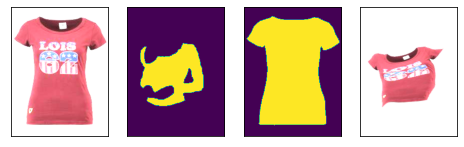

In [23]:
fig = plt.figure(figsize=(8, 20))
ax = fig.add_subplot(1, 4, 1)
plt.imshow(clothes[0].permute(1,2,0).detach().cpu().numpy()+1)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(1, 4, 2)
plt.imshow(fake_cl_dis[0].permute(1,2,0).detach().cpu().numpy())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(1, 4, 3)
plt.imshow(pre_clothes_mask[0].permute(1,2,0).detach().cpu().numpy())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(1, 4, 4)
plt.imshow(warped[0].permute(1,2,0).detach().cpu().numpy()+1)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

In [12]:
warped.size()

torch.Size([1, 3, 256, 192])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'TPS')

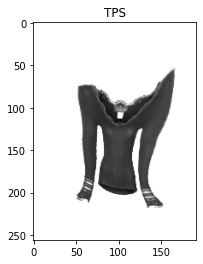

In [13]:
plt.imshow(warped[0].permute(1,2,0).detach().cpu().numpy()+1)
plt.title("TPS")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


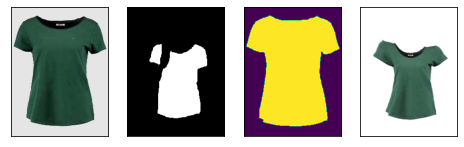

In [16]:
fig = plt.figure(figsize=(8, 20))
ax = fig.add_subplot(1, 4, 1)
plt.imshow(clothes[0].permute(1,2,0).detach().cpu().numpy()+0.9)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(1, 4, 2)
plt.imshow(fake_cl_dis[0].permute(1,2,0).detach().cpu().numpy(), cmap='gray')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(1, 4, 3)
plt.imshow(pre_clothes_mask[0].permute(1,2,0).detach().cpu().numpy())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(1, 4, 4)
plt.imshow(warped[0].permute(1,2,0).detach().cpu().numpy()+1)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

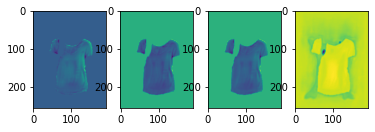

In [15]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1,4)
axarr[0].imshow(fake_c[0][0].detach().cpu().numpy()+1)
axarr[1].imshow(fake_c[0][1].detach().cpu().numpy()+1)
axarr[2].imshow(fake_c[0][2].detach().cpu().numpy()+1)
axarr[3].imshow(fake_c[0][3].detach().cpu().numpy()+1)

In [16]:
mask = fake_c[:, 3, :, :]
mask = sigmoid(mask)*fake_cl_dis
fake_c = tanh(fake_c[:, 0:3, :, :])
fake_c = fake_c*(1-mask)+mask*warped

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


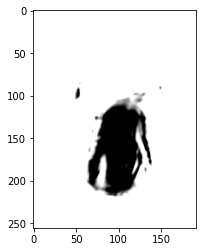

In [15]:
plt.imshow(fake_c[0].permute(1,2,0).detach().cpu().numpy()+0.3)

# Ground Truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


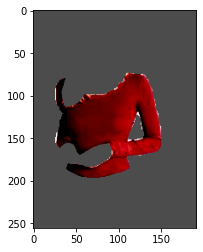

In [25]:
plt.imshow((in_mask_clothes*in_image)[0].permute(1,2,0).detach().cpu().numpy()+0.3)
